In [2]:
setwd("/mnt/c/Users/Cedric/Desktop/git_repos/blood_microbiome")
require(tidyverse)
require(ggplot2)
require(data.table)
require(egg)
require(foreach)
require(doParallel)
registerDoParallel(cores=8)

Loading required package: tidyverse

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: egg

Loading required package: gridExtra


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



## Pre-process data

In [3]:
load_data <- function(file_path) {
    df <- fread(file_path) %>%
        separate(sample, into = c(NA, "npm_research_id"), sep = "\\.")
    return(df)
}

to_retain <- fread("data/samples_above_95_reads.txt")$npm_research_id

species_df <- load_data(str_glue("data/temp_files_9999/07_abundance_matrix/abundance_matrix.subset_9999.S.tsv"))

# rank <- "G"
# genus_df <- load_data(str_glue("data/temp_files_{n_subset}/07_abundance_matrix/abundance_matrix.subset_{n_subset}.{rank}.tsv")) %>%
#     filter(npm_research_id %in% to_retain)

meta <- fread("data/SG10K_Health_metadata.n10714.16March2021.parsed.csv") %>%
    as_tibble()

In [4]:
get_meta_cols <- function(meta) {
    meta_cols <- colnames(meta)[grep("kit|flow_cell|instrument_id|site_supplying", colnames(meta))]
    to_exclude <- c("library_prep_kit", "hiseq_xtm_flow_cell_v2_5_id")
    meta_cols <- meta_cols[!(meta_cols %in% to_exclude)]
    return(meta_cols)
}

meta_cols <- get_meta_cols(meta)
# meta_cols <- c("extraction_kit", "site_supplying_sample", "instrument_id")


### Parameters for simulations

In [5]:
median(meta$error_rate)
med_library_depth <- median(meta$raw_total_sequences)
med_microbial_depth <- median(rowSums(species_df %>% select(-npm_research_id, -unclassified, -"Homo sapiens")))
med_library_depth
median(meta$insert_size_average)


[1] 0.006573206

[1] 373365373

[1] 318

In [6]:
micro_df <- species_df %>% select(-npm_research_id, -unclassified, -"Homo sapiens")
rowsum_df <- tibble(npm_research_id = species_df$npm_research_id, rowsums = rowSums(micro_df))
rowsum_df <- rowsum_df %>%
    left_join(meta) %>%
    mutate(microbe_frac = (rowsums * 2) / raw_total_sequences, .before = 2)
rowsum_df

Joining, by = "npm_research_id"



npm_research_id,microbe_frac,rowsums,multiplex_pool_id,supplier_id,gis_internal_sample_id,site_supplying_sample,year_of_birth,supplied_gender,self_reported_ethnicity,⋯,supplied_and_computed_gender_match,sop_agreement_for_coverage__14/_28_for_15x/30x,sample_life_cycle,current,source_cohort,original_supplier_id,duplicate_info,duplicate,duplicate_pair,removal_requested_by_supplier
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
WHB669,1.965706e-06,377,MUX5172,CG-CTR-0454,TTSH_CG_CTR_0454_1,TTSH,1987,F,Indian,⋯,Y,Y,TTSH VCF,Y,TTSH_mini,CG-CTR-0454,Unknown,PASS,Unknown,Unknown
WHB8678,6.566073e-05,12050,MUX10495,17003-2474,MEC_17003_2474_1,MEC,1980,F,Indian,⋯,Y,Y,MEC VCF,Y,MEC,17003-2474,Unknown,PASS,Unknown,Unknown
WHH7080,4.359685e-05,6725,MUX8946,01999,NTU_01999_1,HELIOS,1957,M,Chinese,⋯,Y,N,HELIOS VCF,Y,HELIOS,01999,Unknown,PASS,Unknown,Unknown
WHB4818,5.442242e-07,183,MUX9298,020-50145,GUSTO_Kids_020_50145_1,GUSTO,2010,F,Chinese,⋯,Y,Y,GUSTO_Kids VCF,Y,GUSTO_Kids,020-50145,Unknown,PASS,Unknown,Unknown
WHB9470,8.387687e-05,15698,MUX9565,02753,HELIOS_02753_1,HELIOS,1961,F,Chinese,⋯,Y,Y,HELIOS VCF,Y,HELIOS,02753,Unknown,PASS,Unknown,Unknown
WHB4637,7.178605e-06,2981,MUX9235,010-20811,GUSTO_Kids_010_20811_1,GUSTO,2010,M,Indian,⋯,Y,Y,GUSTO_Kids VCF,Y,GUSTO_Kids,010-20811,Unknown,PASS,Unknown,Unknown
WHH891,4.837169e-07,77,MUX3434,IS33788,SERI_IS33788_1,SERI,1964,F,Indian,⋯,Y,N,SEED VCF,Y,SEED_mini,IS33788,Unknown,PASS,Unknown,Unknown
WHB3974,1.762617e-05,6233,MUX9016,020-66017,GUSTO_Kids_020_66017_1,GUSTO,2010,M,Chinese,⋯,Y,Y,GUSTO_Kids VCF,Y,GUSTO_Kids,020-66017,Unknown,PASS,Unknown,Unknown
WHB7065,2.328698e-06,416,MUX10137,17003-0861,MEC_17003_0861_1,MEC,1955,M,Chinese,⋯,Y,Y,MEC VCF,Y,MEC,17003-0861,Unknown,PASS,Unknown,Unknown


Warning message:
“Removed 55 rows containing non-finite values (stat_bin).”


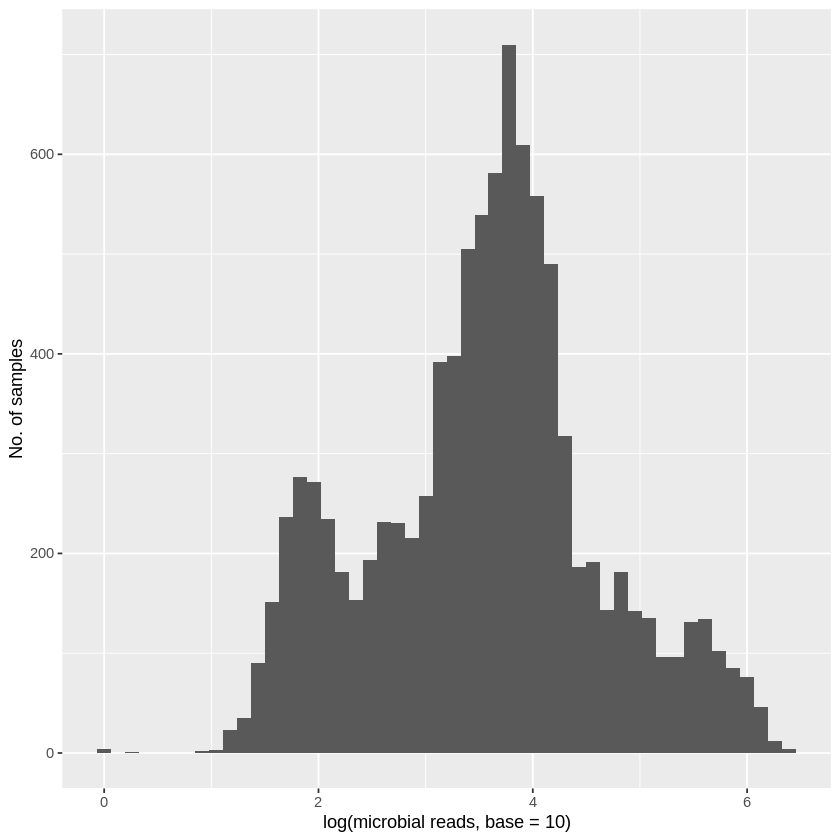

In [7]:
rowsum_df %>% 
    ggplot(aes(x = log(rowsums,base = 10))) +
    geom_histogram(bins = 50) +
    labs(x = "log(microbial reads, base = 10)", y = "No. of samples")

Warning message:
“Removed 55 rows containing non-finite values (stat_bin).”


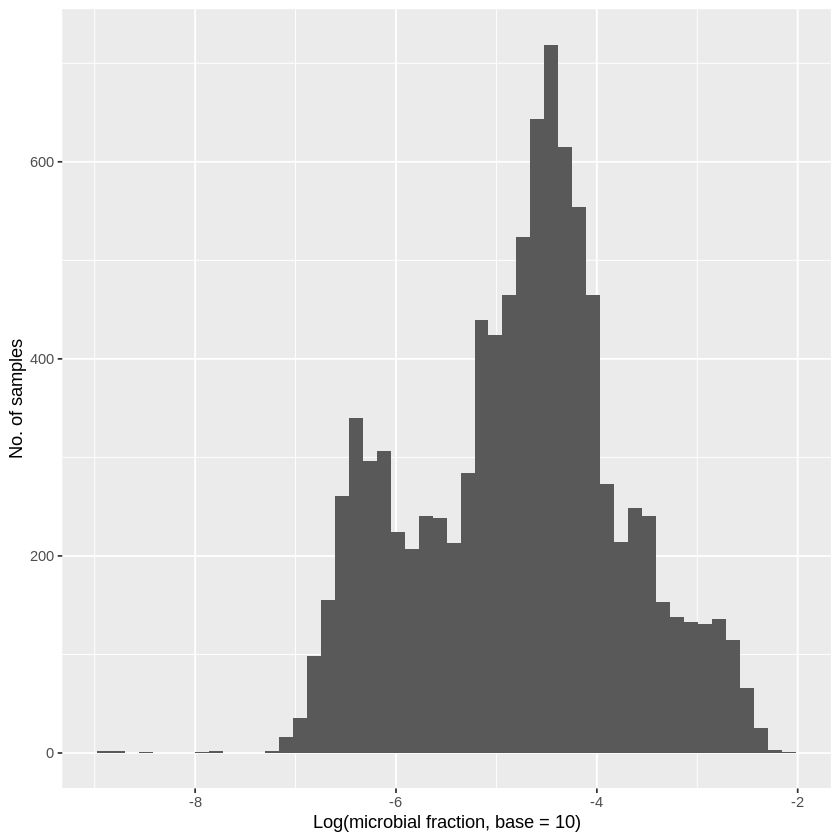

In [8]:
rowsum_df %>% 
#     filter(rowsums < 5000) %>%
    ggplot(aes(x = log(microbe_frac,base = 10))) +
    geom_histogram(bins = 50) +
    labs(x = "Log(microbial fraction, base = 10)", y = "No. of samples")

#### No. of taxa in blanks

In [9]:
care_df <- read.csv("data/reported_controls/raw_files/caregiver.table.s.tsv", sep = "") %>%
  rownames_to_column("taxa")

care_meta <- fread("data/reported_controls/raw_files/caregiver.meta.tsv")

controls <- care_meta %>%
    filter(sample_category == "blank")
controls <- controls$LibraryID

care_df <- care_df %>% 
    select(all_of(c("taxa", controls))) %>%
    mutate(taxa = gsub("\\[|\\]", "", taxa)) %>%
    mutate(taxa = gsub("_", " ", taxa)) %>%
    select(-taxa)

care_df[care_df <= 100] <- 0
care_df[care_df > 100] <- 1

apply(care_df, 2, sum)

WHB11420 WHB11437 WHB11438 WHB11439 WHB11687 
     149      169       88       96      143

# Finding presence absence threshold

#### No. of assigned species per sample

In [10]:
test_prev %>%
    left_join(rowsum_df) %>%
    filter(rowsums <= 100)

ERROR: Error in left_join(., rowsum_df): object 'test_prev' not found


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 55 rows containing non-finite values (stat_bin).”


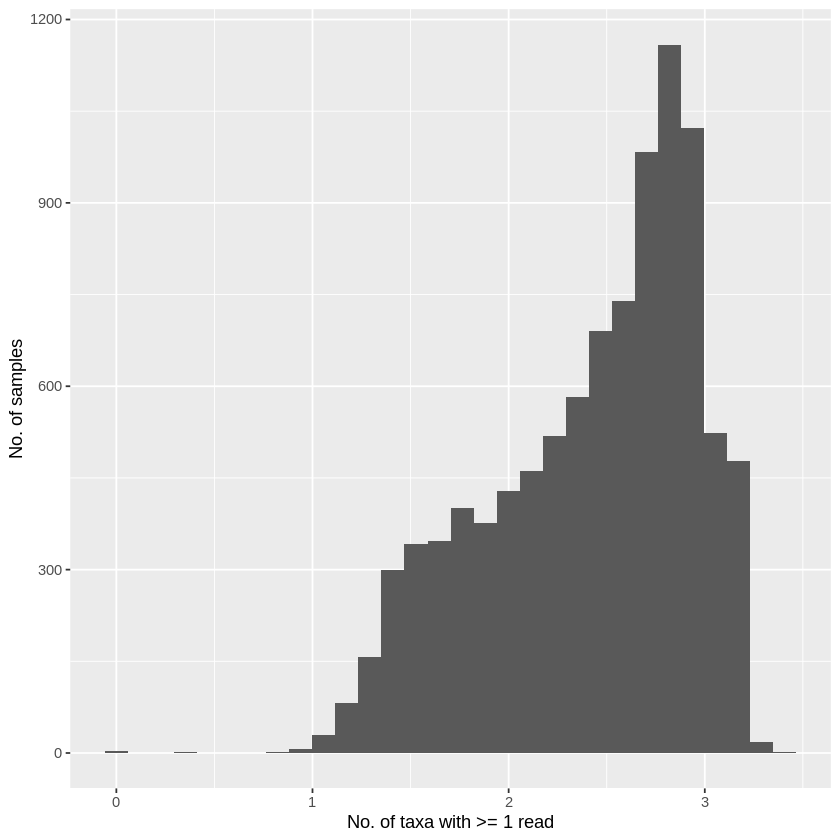

In [9]:
test_prev <- species_df %>%
    select(-npm_research_id, -"Homo sapiens", -unclassified)

test_prev[test_prev <= 0] <- 0
test_prev[test_prev > 0] <- 1

test_prev <- tibble(npm_research_id = species_df$npm_research_id, n_assigned = rowSums(test_prev))
    
test_prev %>%
    ggplot(aes(x = log(n_assigned, base = 10))) +
    geom_histogram() +
    labs(x = "No. of taxa with >= 1 read", y = "No. of samples")

In [1]:
test_prev %>%
    left_join(rowsum_df) %>%
#     mutate(n_assigned = 10 ^ n_assigned) %>%
    ggplot(aes(x = rowsums, y = n_assigned)) +
    geom_point()

ERROR: Error in test_prev %>% left_join(rowsum_df) %>% ggplot(aes(x = rowsums, : could not find function "%>%"


### 10 species simulation (no human)

In [11]:
tp <- c("Yersinia enterocolitica", "Leclercia adecarboxylata", "Moraxella osloensis", 
        "Pasteurella multocida", "Streptococcus pneumoniae", "Streptococcus agalactiae", 
        "Actinomyces viscosus", "Staphylococcus epidermidis", "Torque teno virus", 
        "Human betaherpesvirus 6A")

In [12]:
otu_to_RA <- function(df) {
    row_names <- df$sample
    RA_df <- t(apply(df %>% select(-sample, -unclassified), 1, function(x) {x / sum(x)}))
    
    return(cbind(data.frame(sample = row_names), as.data.frame(RA_df, check.names = F)))
}

parse_df <- function(sim_df) {
    parsed_sim <- sim_df %>% 
        pivot_longer(!sample, names_to = "taxa", values_to = "read_count") %>%
        filter(read_count != 0) %>%
        mutate(classification = case_when(taxa == "unclassified" ~ "Unclassified", 
                                          taxa %in% tp ~ "TP", 
                                          TRUE ~ "FP"),
               sample = gsub("simulated.", "", sample)) %>%
        arrange(desc(classification))

    parsed_sim <- parsed_sim %>% mutate(taxa = factor(taxa, levels = unique(parsed_sim$taxa)))
}

In [13]:
sim_df <- fread("data/simulation_out/07_abundance_matrix/abundance_matrix.subset_.S.tsv")
sim_RA <- otu_to_RA(sim_df)

parsed_sim <- parse_df(sim_df)
parsed_sim_RA <- parse_df(sim_RA)

In [21]:
parsed_sim %>%
    filter(sample == "10e-6")

sample,taxa,read_count,classification
<chr>,<fct>,<dbl>,<chr>
10e-6,unclassified,2,Unclassified
10e-6,Leclercia adecarboxylata,15,TP
10e-6,Yersinia enterocolitica,16,TP
10e-6,Moraxella osloensis,18,TP
10e-6,Pasteurella multocida,18,TP
10e-6,Streptococcus pneumoniae,16,TP
10e-6,Streptococcus agalactiae,3,TP
10e-6,Staphylococcus epidermidis,15,TP
10e-6,Actinomyces viscosus,18,TP


#### No. of assigned species per sample

sample,rowsums
<chr>,<dbl>
simulated.10e-4,15921
simulated.10e-5,1591
simulated.10e-6,157
simulated.10e-3,159268


Joining, by = "sample"



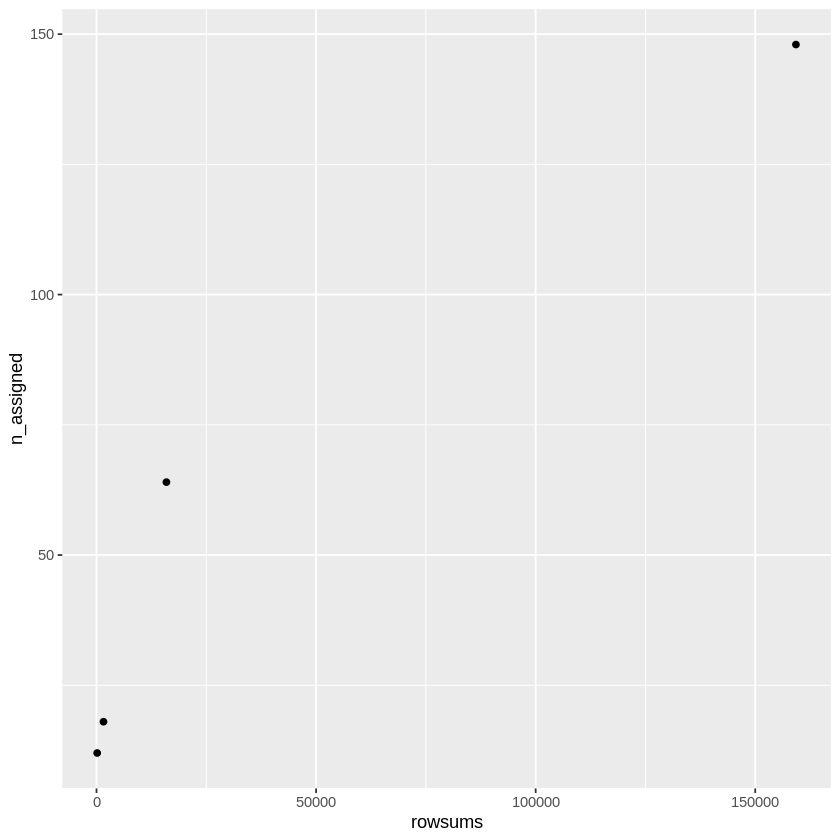

In [14]:
micro_sim <- sim_df %>% select(-sample, -unclassified, -"Homo sapiens")
rowsum_sim <- tibble(sample = sim_df$sample, rowsums = rowSums(micro_sim))

rowsum_sim


sim_prev <- sim_df %>%
    select(-sample, -"Homo sapiens", -unclassified)

sim_prev[sim_prev <= 0] <- 0
sim_prev[sim_prev > 0] <- 1

sim_prev <- tibble(sample = sim_df$sample, n_assigned = rowSums(sim_prev))
    
sim_prev %>%
    left_join(rowsum_sim) %>%
    ggplot(aes(x = rowsums, y = n_assigned)) +
    geom_point() 

v

#### Distribution of read counts for FP/TP

sample,rowsums
<chr>,<dbl>
simulated.10e-4,15921
simulated.10e-5,1591
simulated.10e-6,157
simulated.10e-3,159268


Joining, by = "sample"



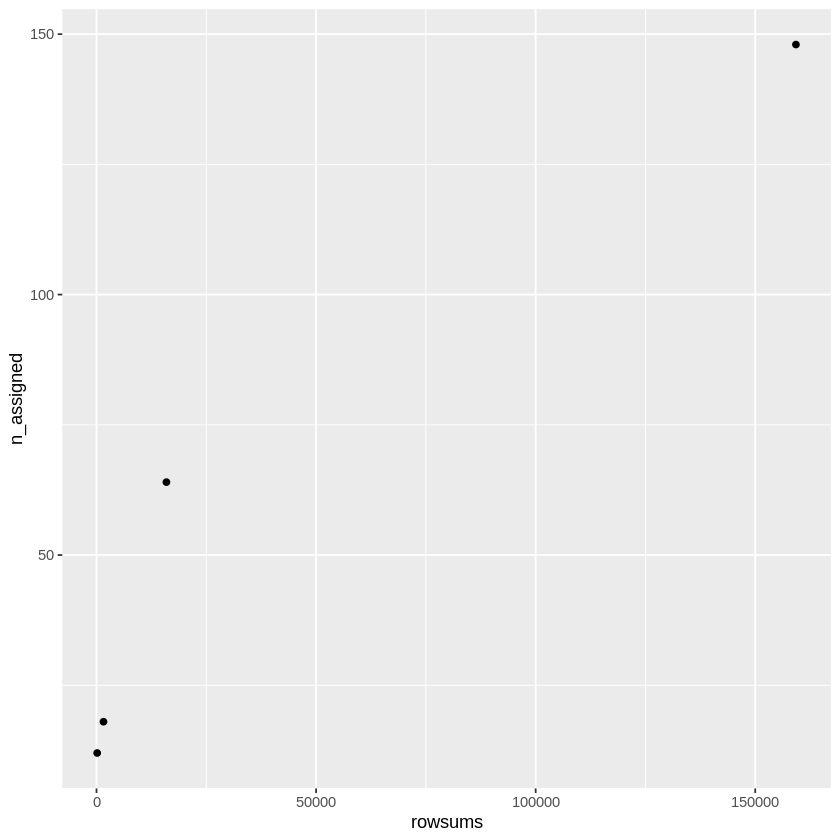

In [14]:
micro_sim <- sim_df %>% select(-sample, -unclassified, -"Homo sapiens")
rowsum_sim <- tibble(sample = sim_df$sample, rowsums = rowSums(micro_sim))

rowsum_sim


sim_prev <- sim_df %>%
    select(-sample, -"Homo sapiens", -unclassified)

sim_prev[sim_prev <= 0] <- 0
sim_prev[sim_prev > 0] <- 1

sim_prev <- tibble(sample = sim_df$sample, n_assigned = rowSums(sim_prev))
    
sim_prev %>%
    left_join(rowsum_sim) %>%
    ggplot(aes(x = rowsums, y = n_assigned)) +
    geom_point() 



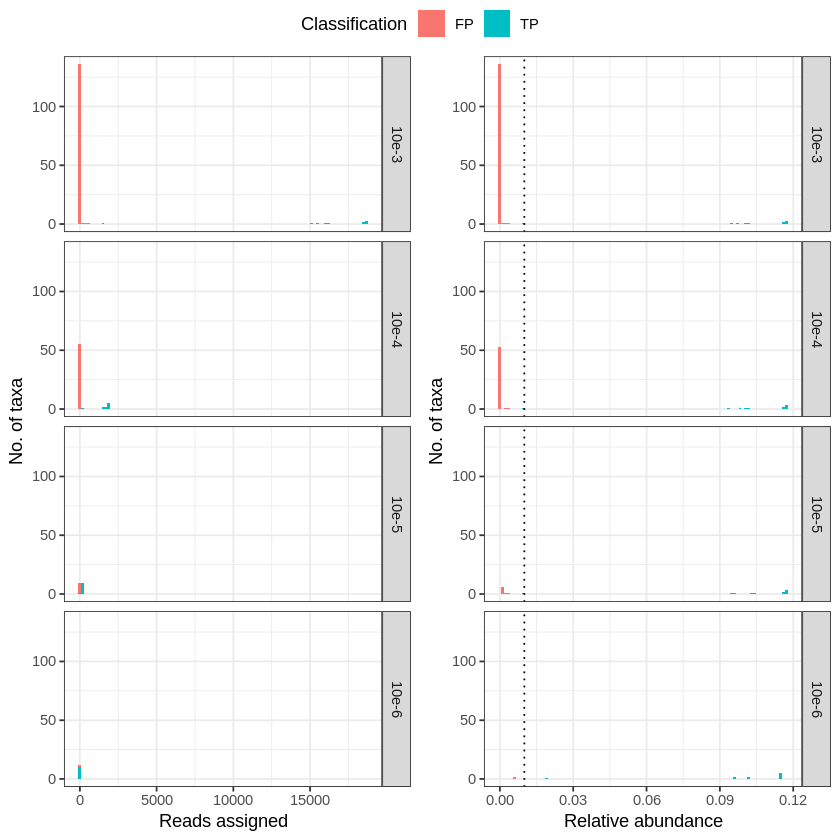

In [67]:
PA_threshold <- 0.01
read_plt <- parsed_sim %>%
    filter(classification != "Unclassified") %>%
    ggplot(aes(x = read_count, fill = classification)) +
    theme_bw() +
    geom_histogram(bins = 100) +
    facet_grid(rows = vars(sample)) +
    labs(x = "Reads assigned", y = "No. of taxa", fill = "Classification")
RA_plt <- parsed_sim_RA %>% 
    ggplot(aes(x = read_count, fill = classification)) +
    theme_bw() +
    geom_histogram(bins = 100) +
    facet_grid(rows = vars(sample)) +
    labs(x = "Relative abundance", y = "No. of taxa", fill = "Classification") +
    geom_vline(xintercept = PA_threshold, color = "black", linetype = "dotted")

combined <- ggpubr::ggarrange(read_plt, RA_plt, ncol = 2, common.legend = T)
combined
ggsave("results/simulations/abundance_distribution_fp_tp.png", dpi = 300, plot = combined, width = 7, height = 4)

In [19]:
parsed_sim_RA %>%
    filter(read_count < 0.05, classification == "TP")

sample,taxa,read_count,classification
<chr>,<fct>,<dbl>,<chr>
10e-4,Streptococcus agalactiae,0.009669722,TP
10e-5,Streptococcus agalactiae,0.010056568,TP
10e-6,Streptococcus agalactiae,0.019108280,TP
10e-3,Streptococcus agalactiae,0.009754260,TP


### Read counts for each microbial depth

In [20]:
plots <- foreach(sim_run = c("simulated.10e-3", "simulated.10e-4", "simulated.10e-5", "simulated.10e-6")) %do% {
    parsed_sim %>%
        filter(sample == sim_run) %>%
        ggplot(aes(x = taxa, y = read_count, fill = classification)) +
        geom_bar(stat = "identity") +
        labs(x = "Taxa", y = "Reads assigned", fill = "Taxon classification") +
        theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
        facet_grid(cols = vars(sample))
}

ERROR while rich displaying an object: Error: Faceting variables must have at least one value

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.default(obj)
9. paste

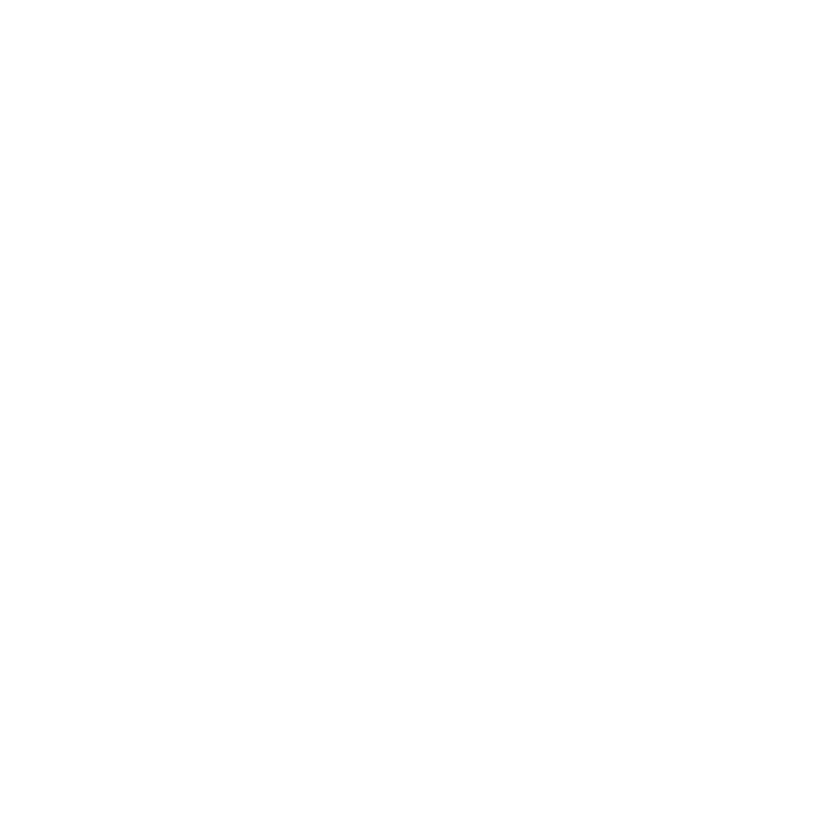

In [21]:
plots